##### Импорт библиотек

In [375]:
import requests as r
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import plotly as pt
import plotly.express as px
import os
from dotenv import load_dotenv
from pathlib import Path

In [376]:
load_dotenv()  # загружаются переменные из файла
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

visit_json = r.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
registration_json = r.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")

data_vis=visit_json.json()
visits=pd.DataFrame(data_vis)

data_reg=registration_json.json()
registrations=pd.DataFrame(data_reg)

##### Задание 3

In [377]:
#Подавление ошибки цепного назначения
pd.options.mode.chained_assignment = None

#Раскрываем все строки и столбцы
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Добавляем столбец с датой
visits['date'] = pd.to_datetime(visits['datetime']).dt.date
registrations['date'] = pd.to_datetime(registrations['datetime']).dt.date

#Выбираем дату последнего визита каждого пользователя
visits["datetime"] = pd.to_datetime(visits["datetime"], format="%a, %d %b %Y %H:%M:%S %Z")
visits["last_datetime"] = visits.groupby('visit_id')["datetime"].transform('max')
visits = visits[visits['datetime'] == visits['last_datetime']]

#Маркируем ботов
visits['is_bot'] = np.where(visits['user_agent'].str.contains('bot'), 'yes', 'no')

In [378]:
#Группируем и объединяем данные
visits_and_registrations = pd.concat([
    visits[visits['is_bot'] == 'no'].groupby(['date', 'platform']).agg({'visit_id': 'count'}),
    registrations.groupby(['date', 'platform']).agg({'user_id': 'count'})
], axis = 1).reset_index()

#Переименовываем столбцы и заполняем нули
visits_and_registrations.rename(columns = {'date':'date_group', 'visit_id':'visits', 'user_id':'registrations'}, inplace = True )
visits_and_registrations['registrations'] = visits_and_registrations['registrations'].fillna(0)

#Считаем конверсию
visits_and_registrations['conversion'] = round(visits_and_registrations['registrations']/visits_and_registrations['visits']*100, 0)

#Сохраняем в формате json
visits_and_registrations.to_json('conversion.json', orient = 'columns')

##### Задание 4

In [379]:
#Читаем данные из csv файла
ads_info = pd.read_csv('ads.csv')

#Добавляем столбец с датой
ads_info['date_ymd'] = pd.to_datetime(ads_info['date']).dt.date

#Группируем по дате и рекламной компании, находим стоимость рекламных кампаний по дням
ads_grouped = ads_info.groupby(['date_ymd', 'utm_campaign']).agg({'cost':'sum'}).reset_index()

#Соединяем таблицу конверсий и рекламы, переименовываем столбцы
ads = visits_and_registrations.merge(ads_grouped, left_on = 'date_group', right_on = 'date_ymd', how = 'left') 
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
ads['cost'] = ads['cost'].fillna(0)
ads['utm_campaign'] = ads['utm_campaign'].fillna('none')

#Сохраняем в формате json
ads.to_json('ads.json', orient = 'columns')
print(ads.head(10))

   date_group  visits  registrations   cost              utm_campaign
0  2023-03-01      75             61  238.0  virtual_reality_workshop
1  2023-03-01      22             18  238.0  virtual_reality_workshop
2  2023-03-01     279              8  238.0  virtual_reality_workshop
3  2023-03-02      67             59  164.0  virtual_reality_workshop
4  2023-03-02      31             24  164.0  virtual_reality_workshop
5  2023-03-02     515             23  164.0  virtual_reality_workshop
6  2023-03-03      26             22  240.0  virtual_reality_workshop
7  2023-03-03      40             34  240.0  virtual_reality_workshop
8  2023-03-03     617             51  240.0  virtual_reality_workshop
9  2023-03-04      94             77  167.0  virtual_reality_workshop


##### Задание 5

###### *Итоговые визиты*

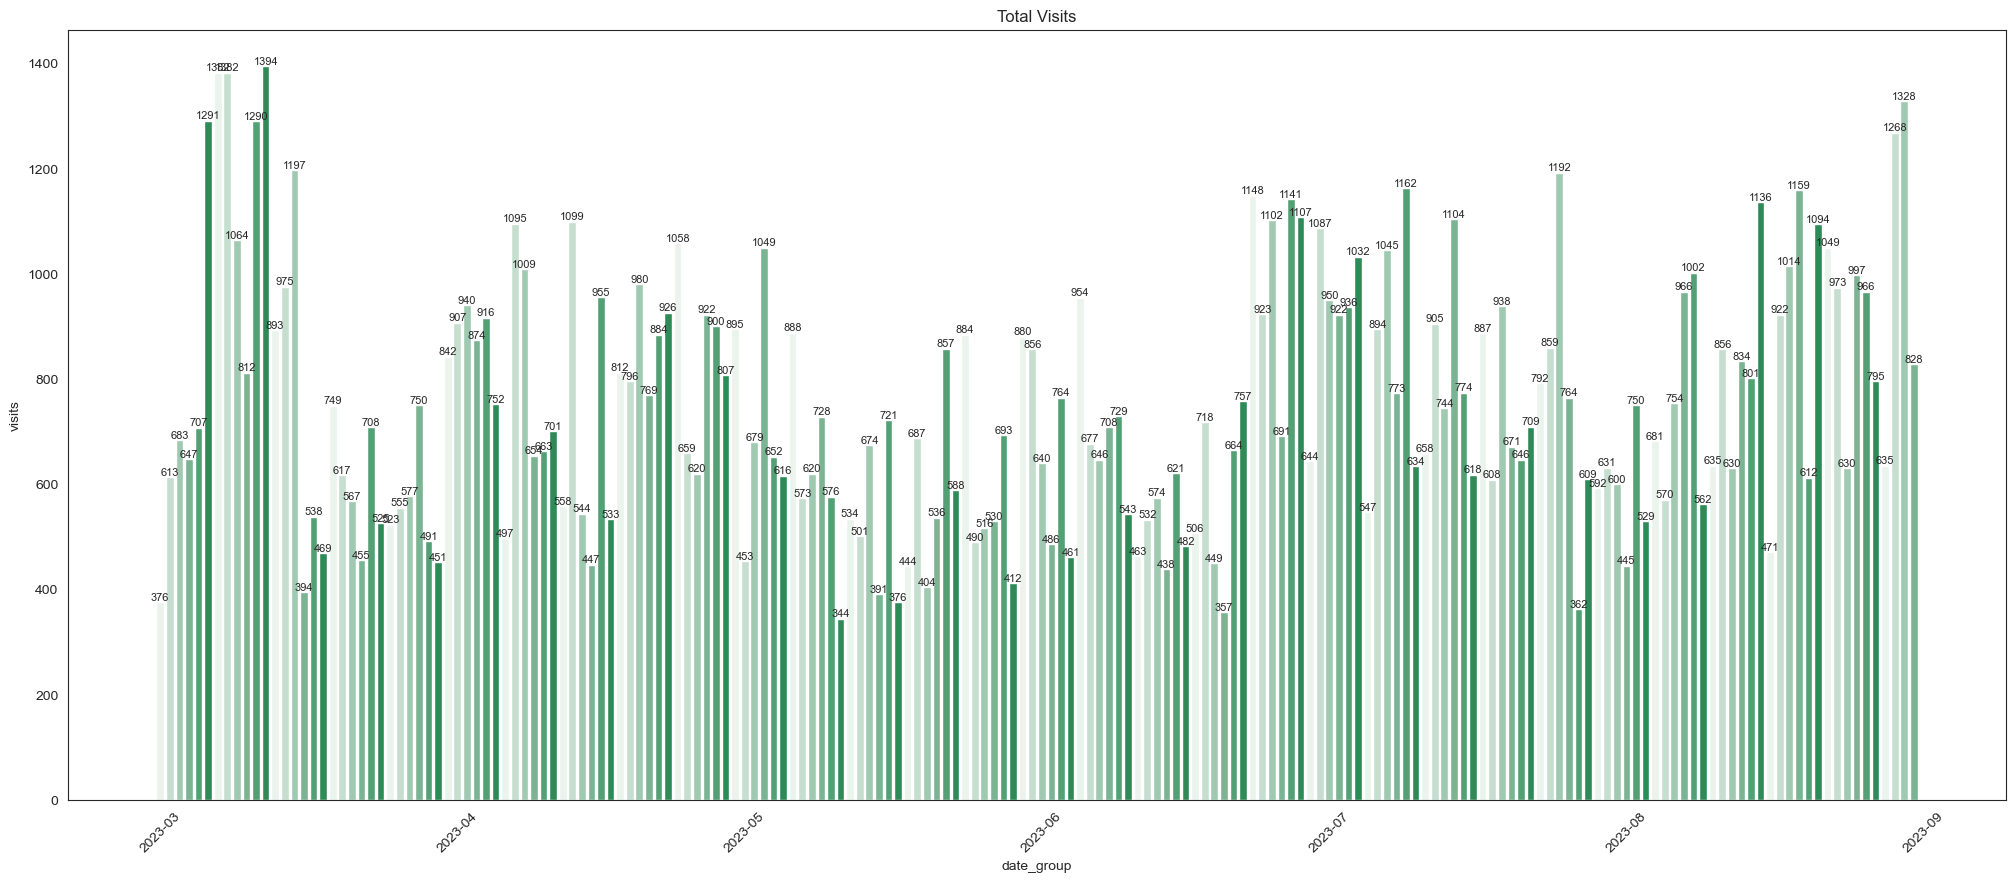

In [380]:
total_visits = ads.groupby(['date_group']).agg({'visits':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(25, 10))
plt.bar(total_visits['date_group'], total_visits['visits'], color=sns.light_palette("seagreen"))
ax.bar_label(ax.containers[0], fontsize=8)
sns.set_style("white")
plt.xticks(rotation = 45)
plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Total Visits')
plt.savefig(f'./charts/Total Visits.png')
plt.show()

###### *Итоговые визиты с разбивкой по платформам*

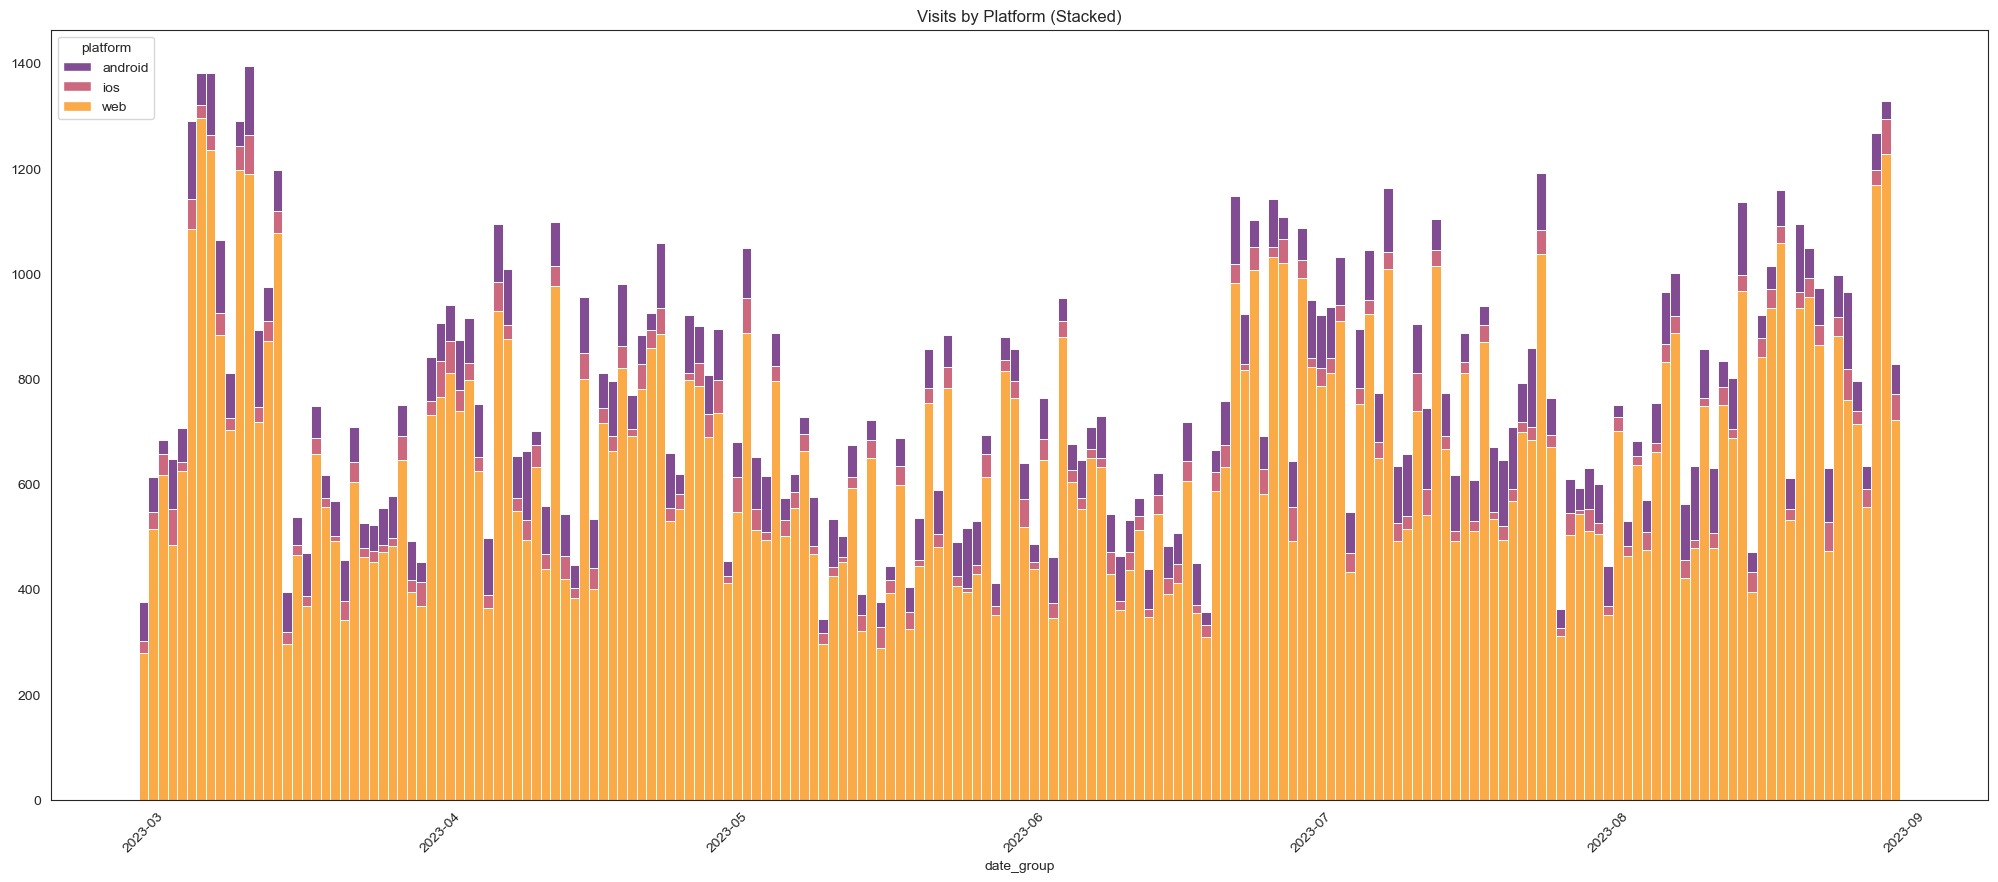

In [381]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(x='date_group', weights='visits', hue = 'platform', data=visits_and_registrations, palette = 'inferno', multiple='stack')
sns.set_style("whitegrid")
plt.xticks(rotation = 45)
plt.xlabel('date_group')
plt.ylabel('')
plt.title('Visits by Platform (Stacked)')
plt.savefig(f'./charts/Visits by Platform (Stacked).png')
plt.show()

###### *Итоговые регистрации*

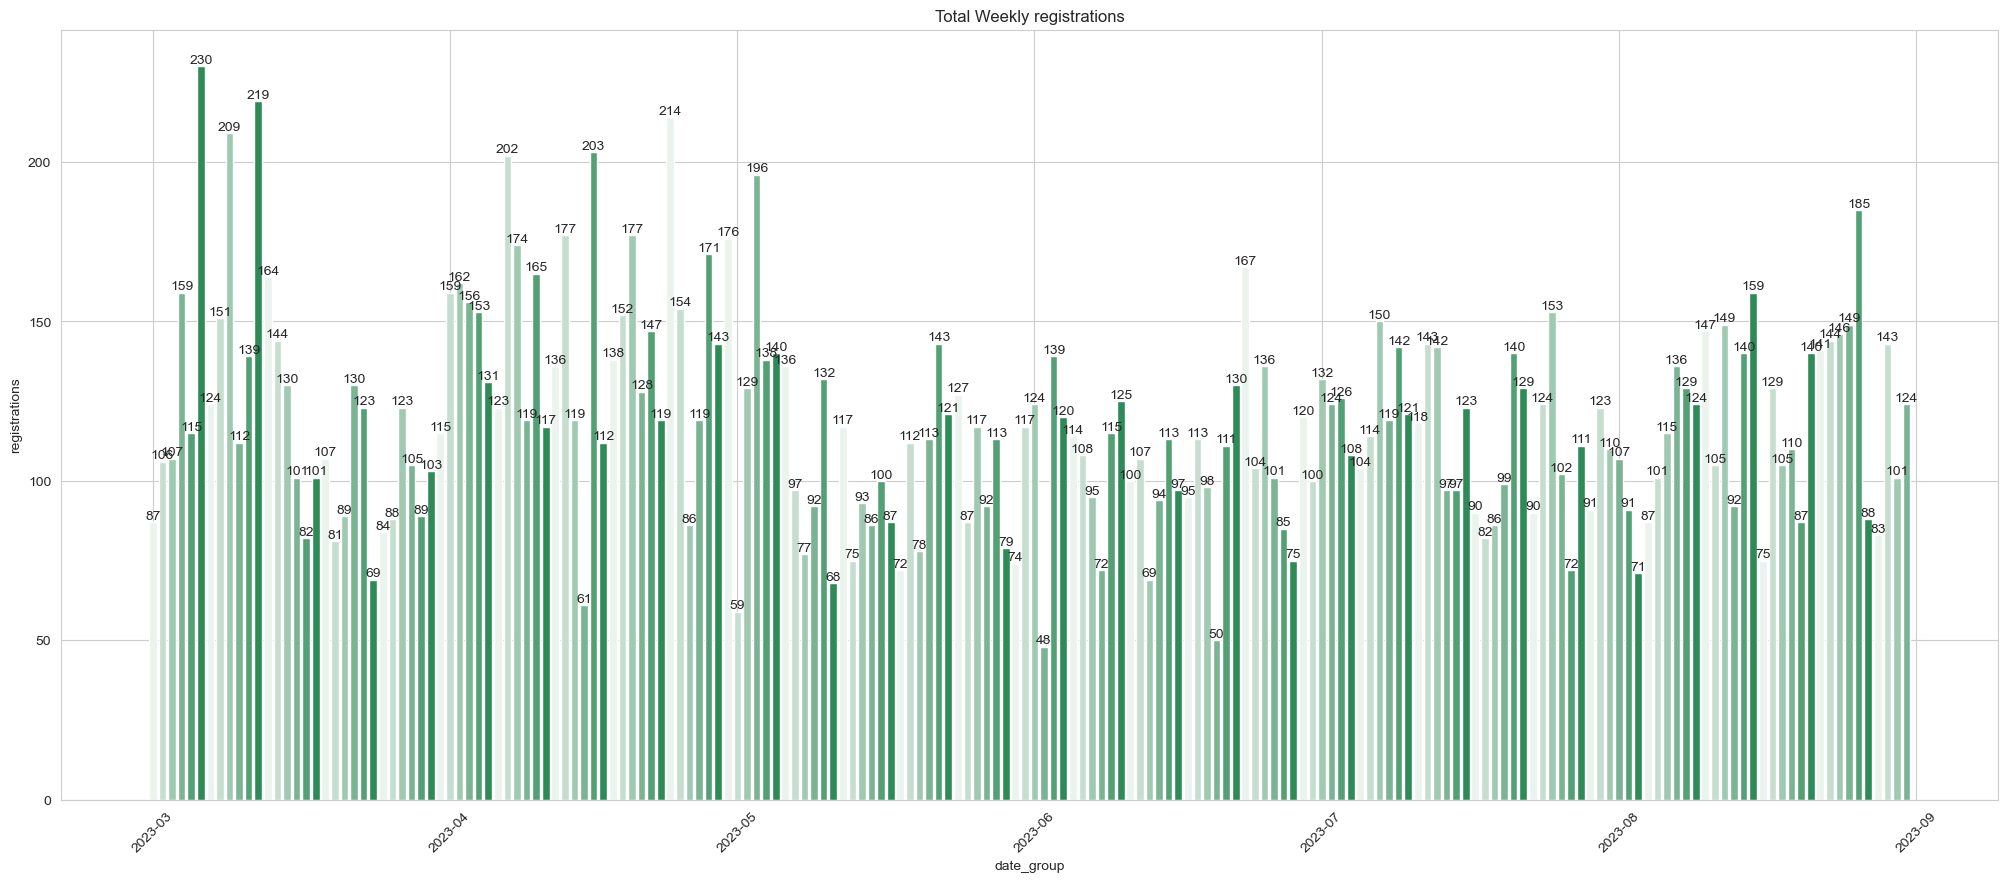

In [382]:
total_registrations = ads.groupby(['date_group']).agg({'registrations':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(25, 10))
plt.bar(total_registrations['date_group'], total_registrations['registrations'], color=sns.light_palette("seagreen"))
ax.bar_label(ax.containers[0], fontsize=10)
sns.set_style("white")
plt.xticks(rotation = 45)
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Total Weekly registrations')
plt.savefig(f'./charts/Total Weekly registrations.png')
plt.show()

###### *Итоговые регистрации с разбивкой по платформе*

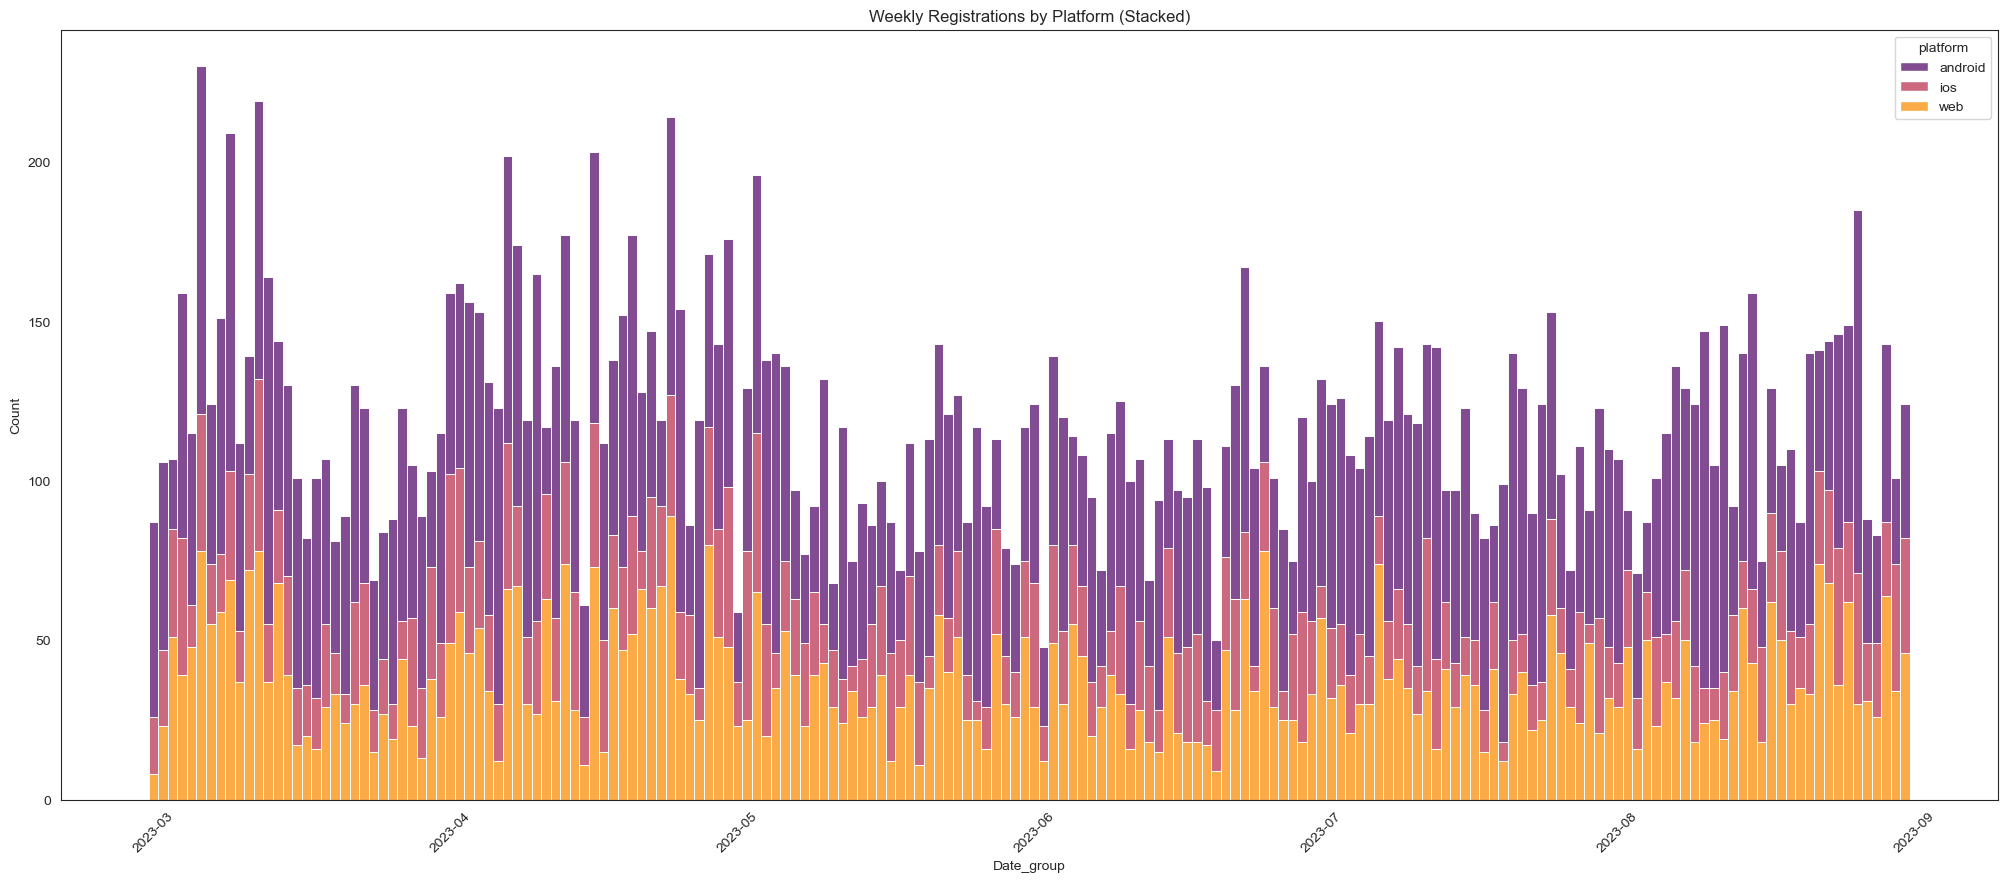

In [383]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(x='date_group', weights='registrations', hue = 'platform', data=visits_and_registrations, palette = 'inferno', multiple='stack')
sns.set_style("whitegrid")
plt.xticks(rotation = 45)
plt.xlabel('Date_group')
plt.title('Weekly Registrations by Platform (Stacked)')
plt.savefig(f'./charts/Weekly Registrations by Platform (Stacked).png')
plt.show()

###### *Итоговые регистрации с разбивкой по типу регистрации*

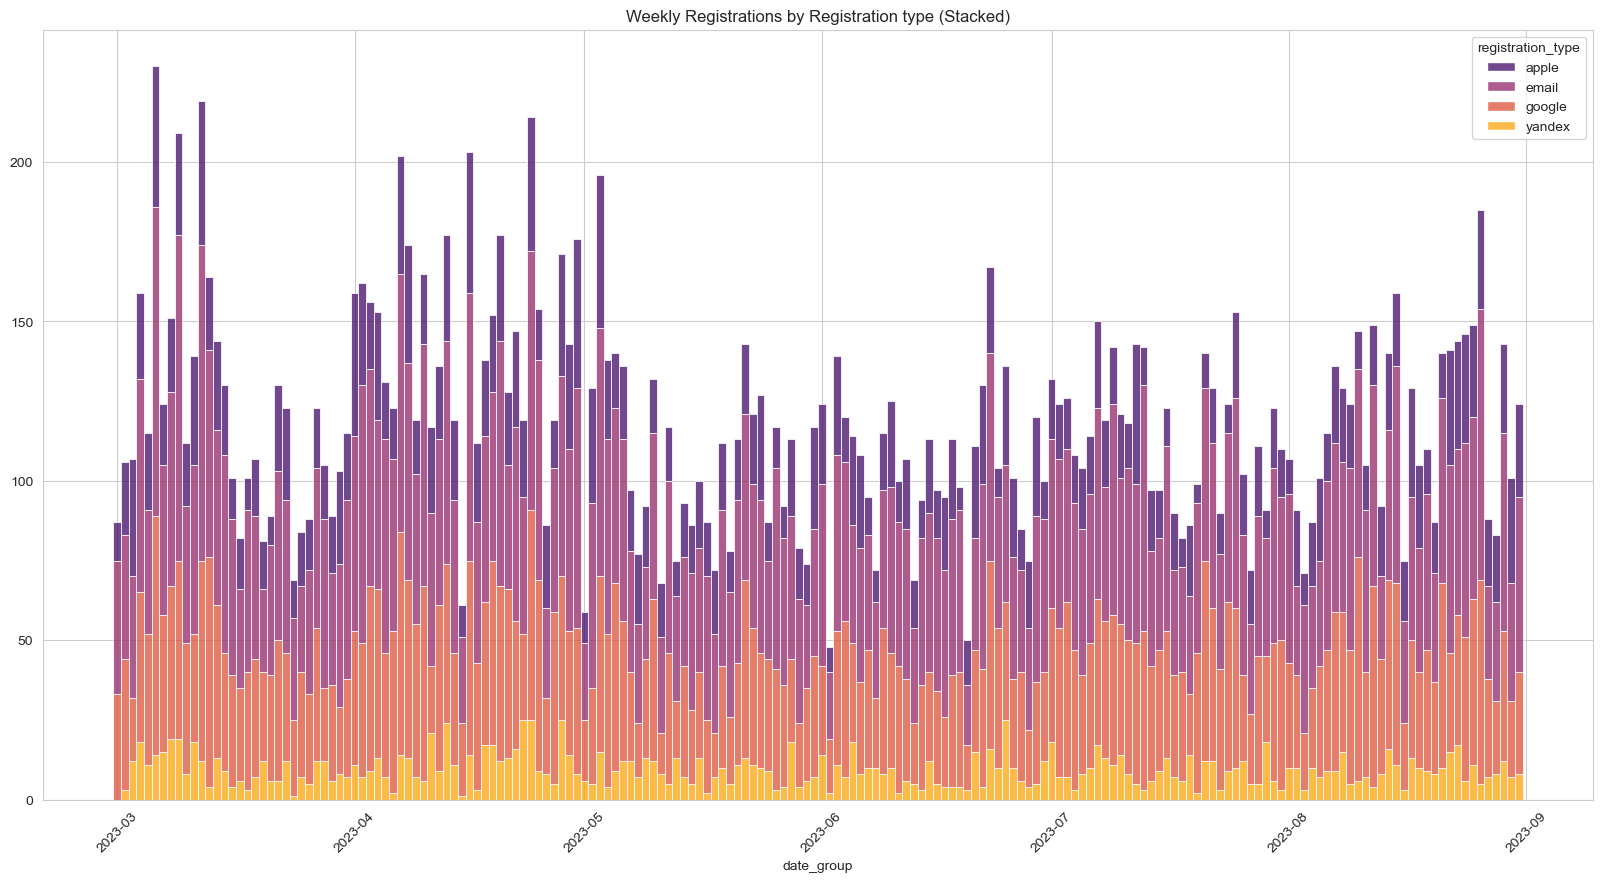

In [384]:
reg_types = registrations.groupby(['date', 'registration_type']).agg({'user_id':'count'}).reset_index()
reg_types.rename(columns = {'user_id':'count'}, inplace = True )

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date', weights='count', hue = 'registration_type', data=reg_types, palette = 'inferno', multiple='stack')
sns.set_style("whitegrid")
plt.xticks(rotation = 45)
plt.xlabel('date_group')
plt.ylabel('')
plt.title('Weekly Registrations by Registration type (Stacked)')
plt.savefig(f'./charts/Weekly Registrations by Registration type (Stacked).png')
plt.show()

###### *Итоговые регистрации с разбивкой по платформе - pie chart*

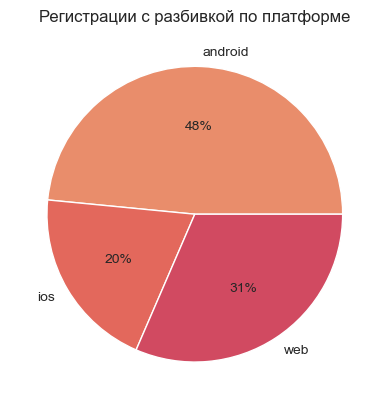

In [385]:
platforms_pie_info = visits_and_registrations.groupby(['platform']).agg({'registrations':'sum'}).reset_index()

colors = sns.color_palette('flare')[ 0:100 ]
plt.pie(platforms_pie_info['registrations'], labels = platforms_pie_info['platform'], colors = colors, autopct='%.0f%%')
plt.title('Регистрации с разбивкой по платформе')
plt.show()

###### *Итоговые регистрации с разбивкой по типу регистрации - pie chart*

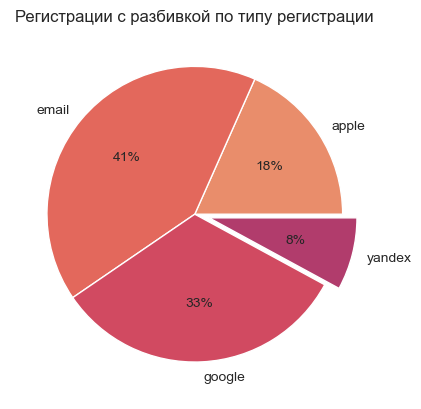

In [386]:
types_pie_info = reg_types.groupby(['registration_type']).agg({'count':'sum'}).reset_index()

colors = sns.color_palette('flare')[ 0:100 ]
plt.pie(types_pie_info['count'], labels = types_pie_info['registration_type'], colors = colors, autopct='%.0f%%', explode = [0, 0, 0, 0.1])
plt.title('Регистрации с разбивкой по типу регистрации')
plt.show()

###### *Итоговые конверсии*

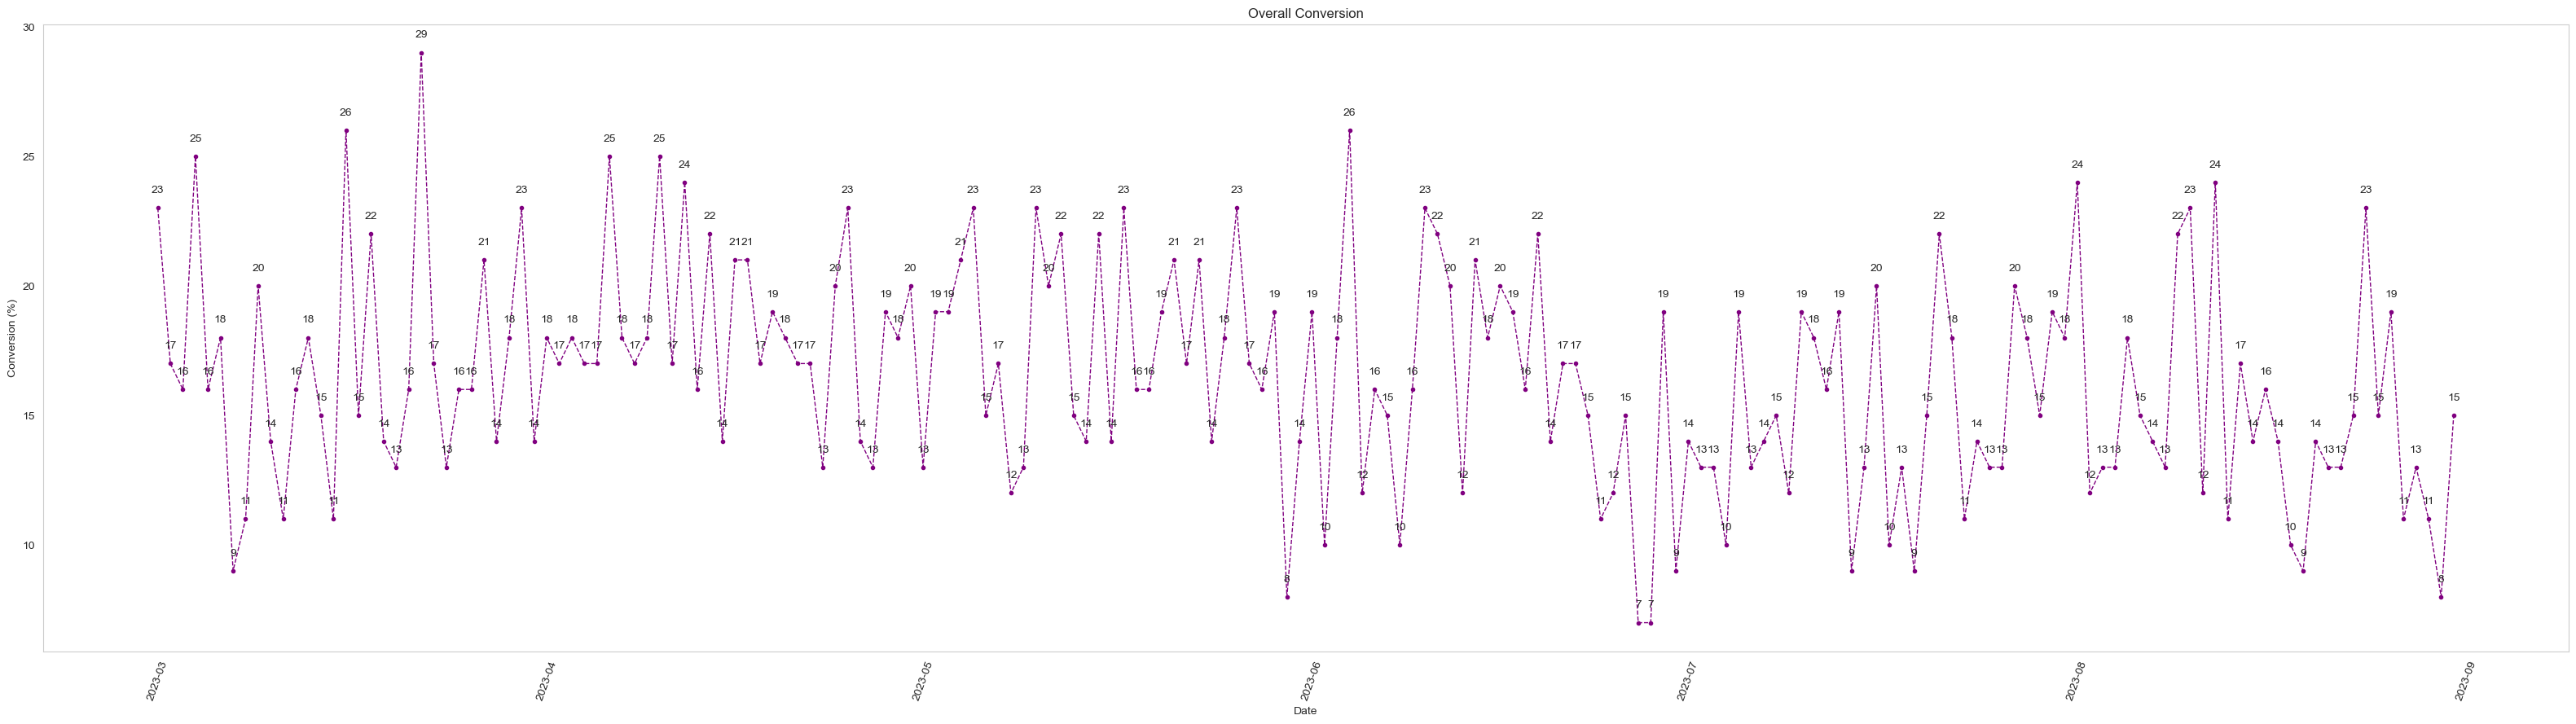

In [387]:
visits_per_day = visits_and_registrations.groupby(['date_group']).agg({'visits':'sum'})
registrations_per_day = visits_and_registrations.groupby(['date_group']).agg({'registrations':'sum'})
total_conversion = round(registrations_per_day['registrations']/visits_per_day['visits']*100, 0).reset_index()
total_conversion = total_conversion.set_axis(['date_group', 'conversion'], axis=1, copy = False)

fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(total_conversion['date_group'], total_conversion['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.xticks(rotation=70)
for x, y in zip(total_conversion['date_group'], total_conversion['conversion']):
    plt.text(x, y + 0.5, '%d' % y, ha='center', va = 'bottom')
plt.savefig(f'./charts/Overall Conversion.png')
plt.show()



###### *Итоговые конверсии Android*

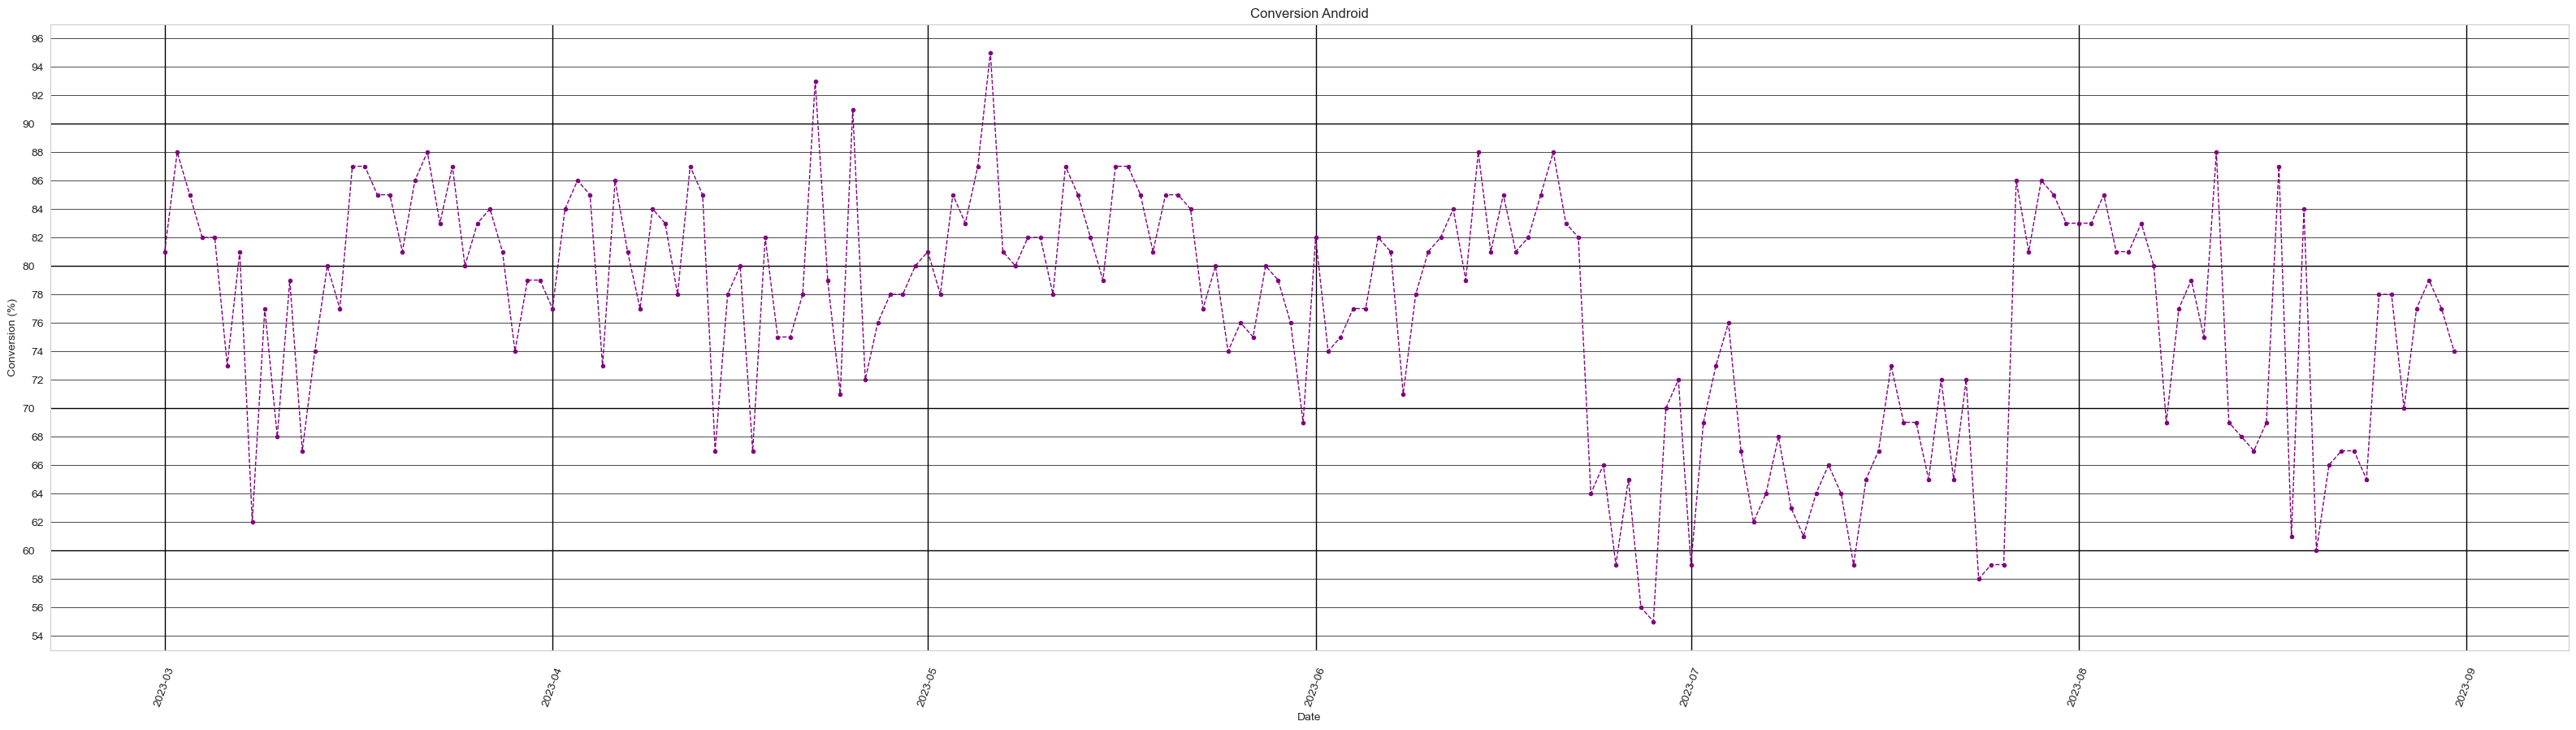

In [388]:
visits_and_registrations_android = visits_and_registrations[visits_and_registrations['platform'] == 'android']

fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(visits_and_registrations_android['date_group'], visits_and_registrations_android['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
plt.title('Conversion Android')
plt.xticks(rotation=70)
plt.grid()

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter('{x:.0f}')

ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=2, )

plt.savefig(f'./charts/Conversion Android.png')
plt.show()

###### *Итоговые конверсии Ios*

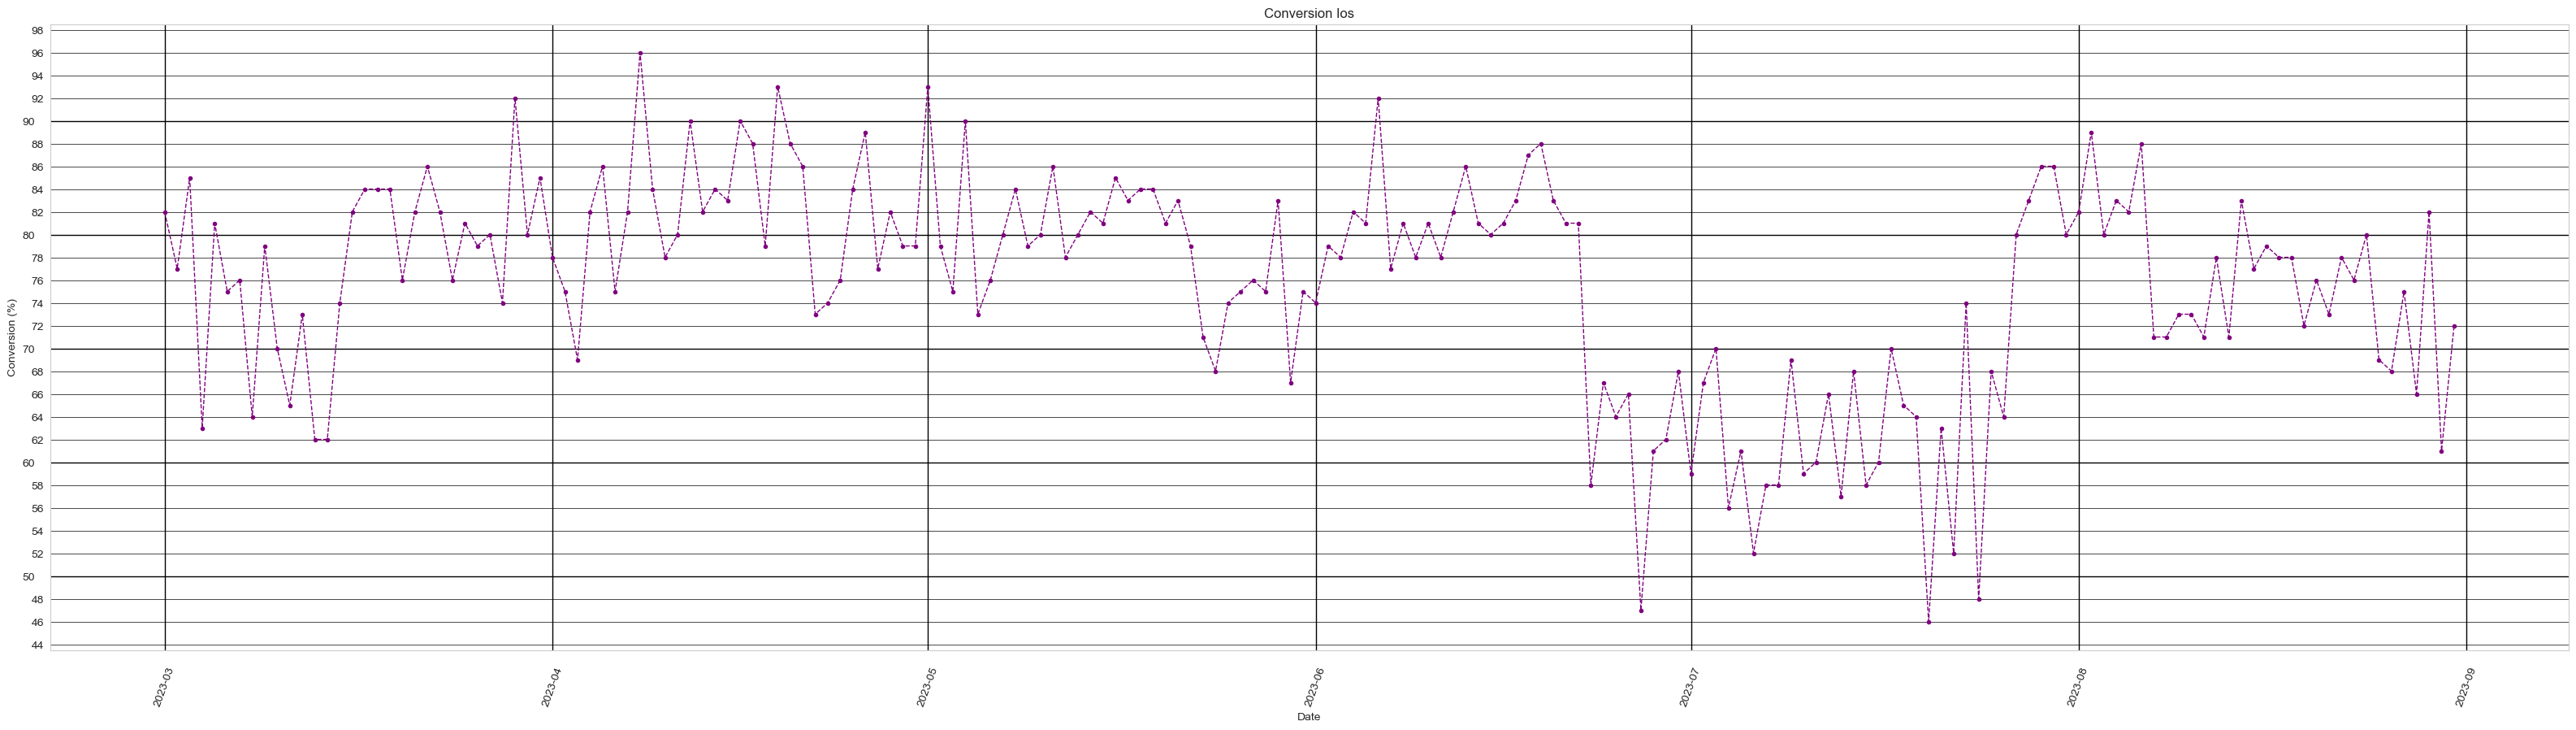

In [389]:
visits_and_registrations_ios = visits_and_registrations[visits_and_registrations['platform'] == 'ios']

fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(visits_and_registrations_ios['date_group'], visits_and_registrations_ios['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
plt.title('Conversion Ios')
plt.xticks(rotation=70)

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter('{x:.0f}')

ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=2, )

plt.savefig(f'./charts/Conversion Ios.png')
plt.show()

###### *Итоговые конверсии Web*

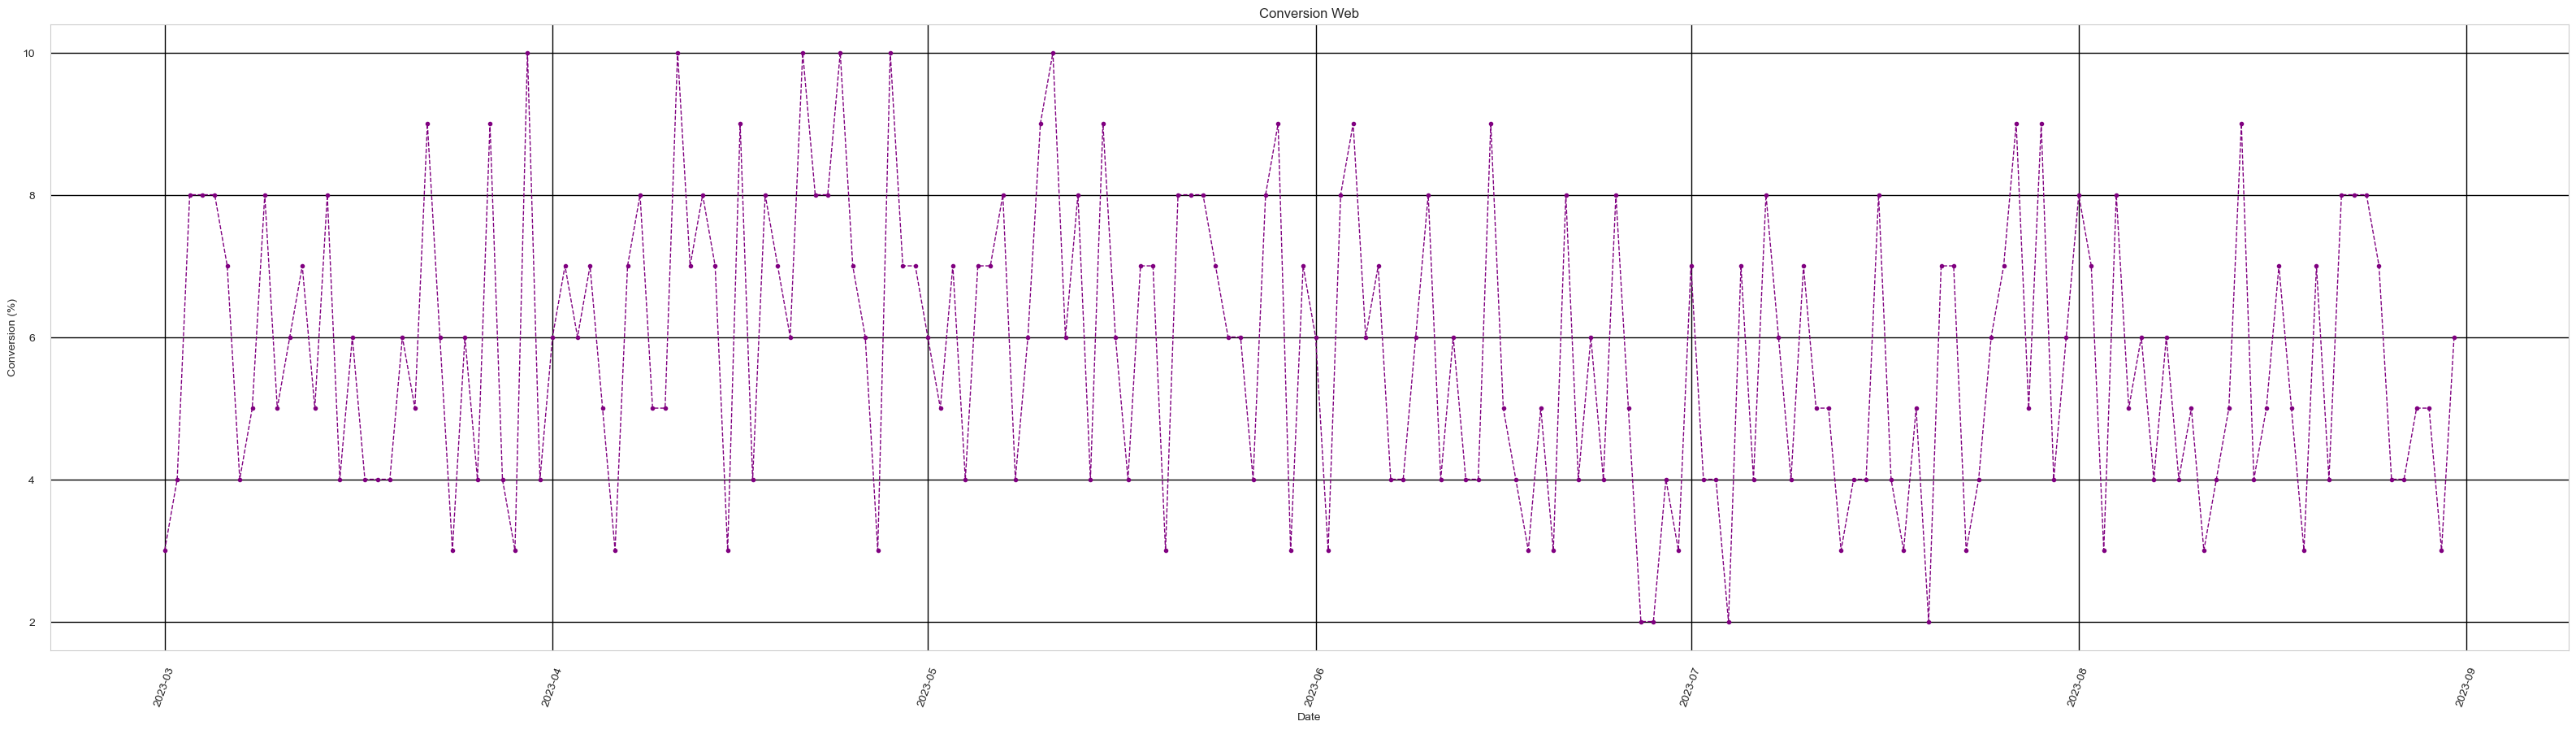

In [390]:
visits_and_registrations_web = visits_and_registrations[visits_and_registrations['platform'] == 'web']

fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(visits_and_registrations_web['date_group'], visits_and_registrations_web['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
plt.title('Conversion Web')
plt.xticks(rotation=70)

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter('{x:.0f}')

# ax.yaxis.set_minor_locator(MultipleLocator(0.5))
# ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=2, )

plt.savefig(f'./charts/Conversion Web.png')
plt.show()

###### *Стоимость реклам*

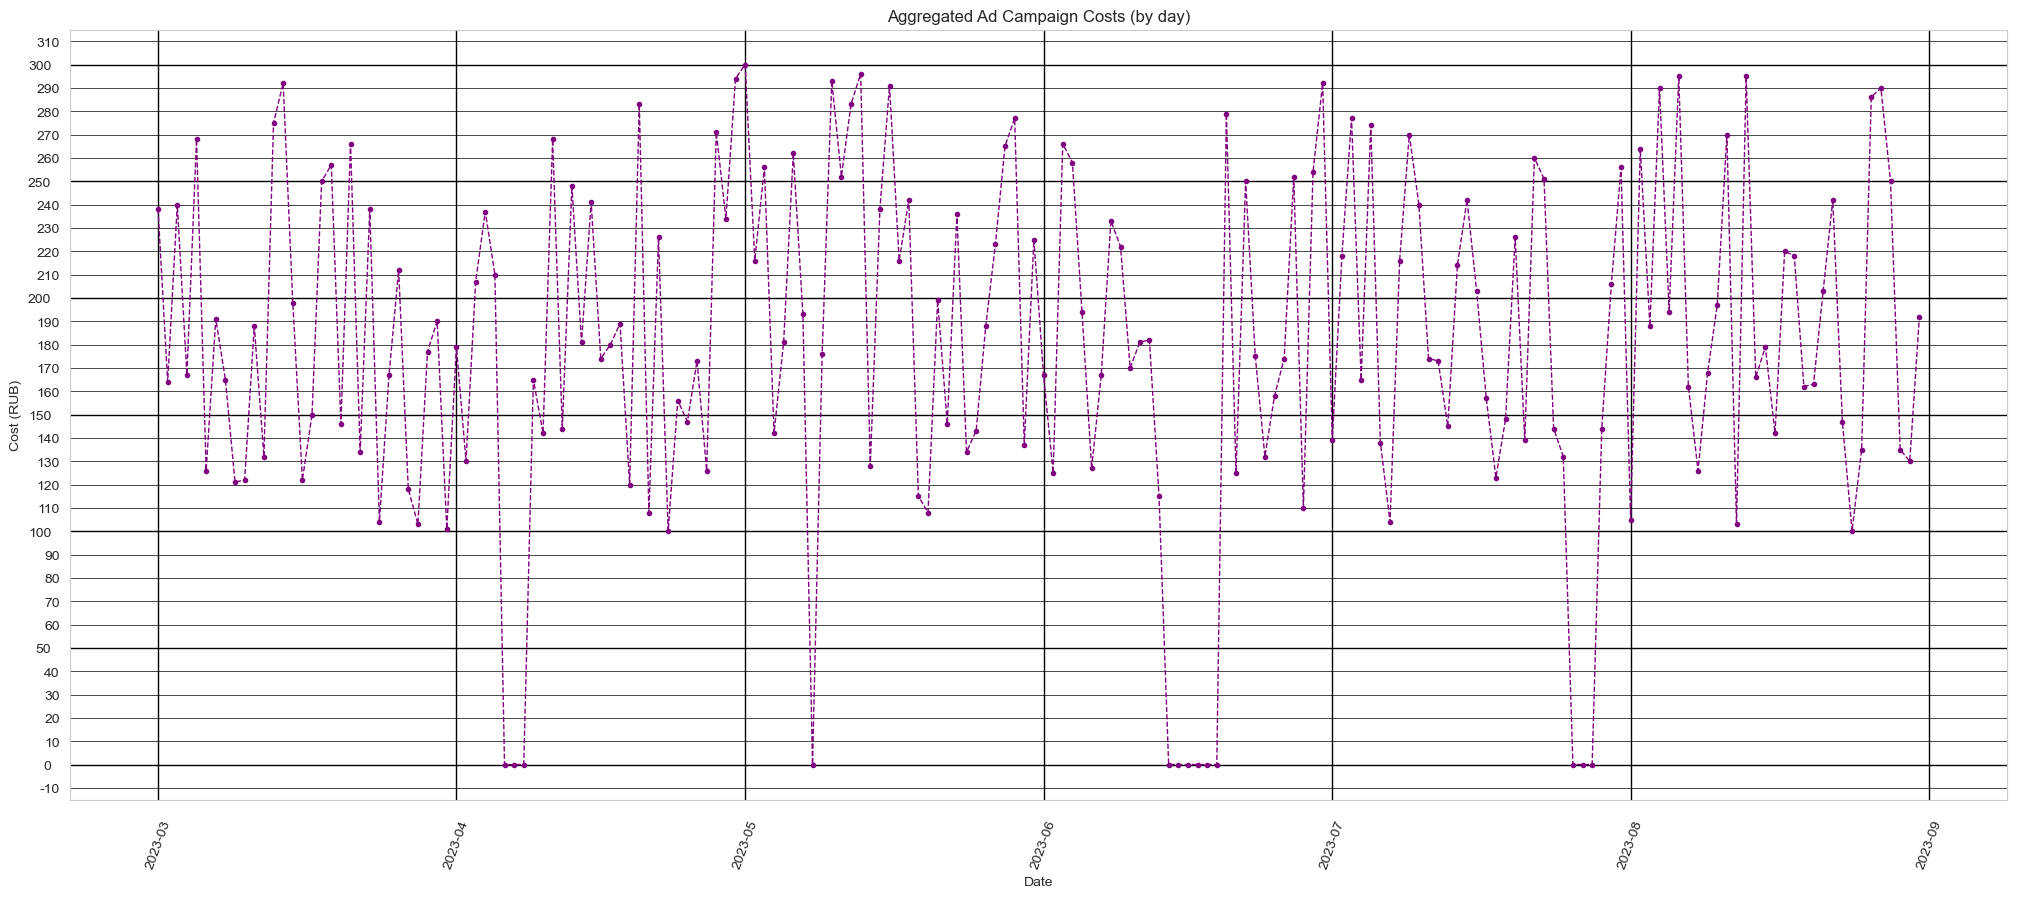

In [391]:
ads_per_day = ads.loc[::3, ['date_group', 'cost']]

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(ads_per_day['date_group'], ads_per_day['cost'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Cost (RUB)')
plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xticks(rotation=70)

ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter('{x:.0f}')

ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=4, )
plt.savefig(f'./charts/Aggregated Ad Campaign Costs (by day).png')
plt.show()

###### *Визиты с выделением рекламных кампаний*

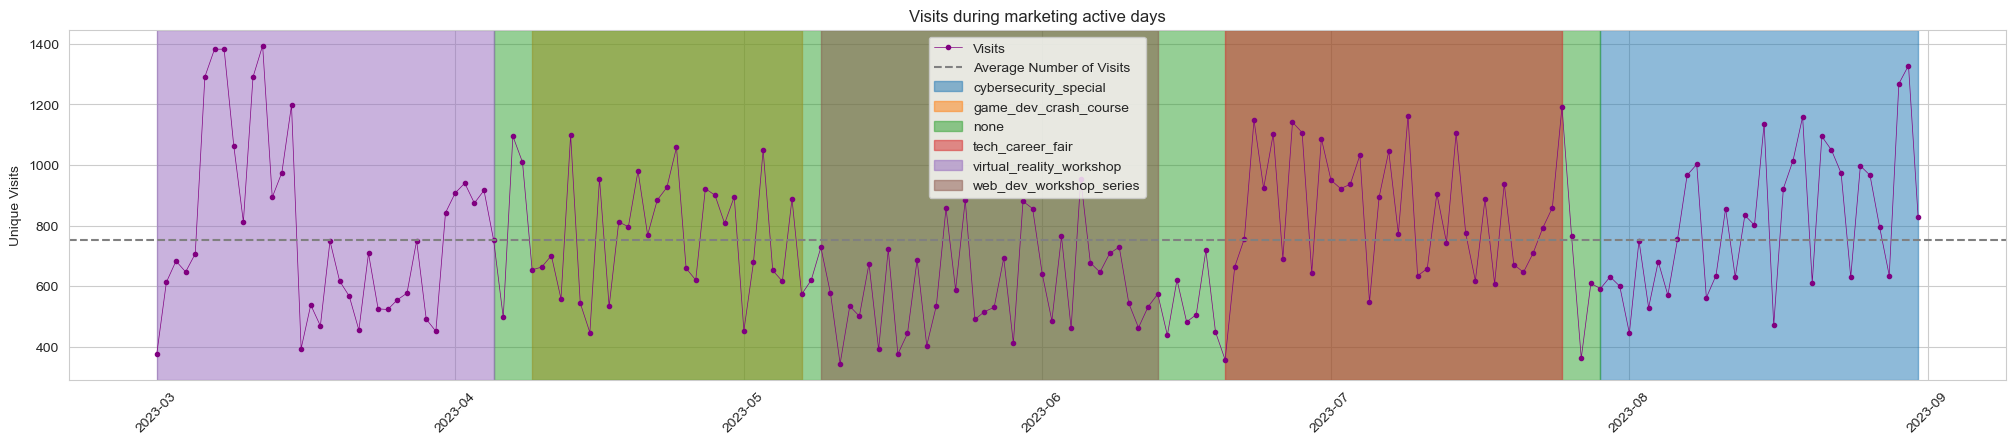

In [392]:
visits_from_utm_campaign = ads.groupby(['date_group', 'utm_campaign']).agg({'visits':'sum'}).reset_index()
ads_periods = visits_from_utm_campaign[['utm_campaign', 'date_group']].groupby('utm_campaign').apply(lambda x : x.loc[(x['date_group'] == x['date_group'].min()) | (x['date_group'] == x['date_group'].max())]).reset_index(drop=True)
ads_start = ads_periods.groupby('utm_campaign')['date_group'].agg('min').reset_index()
ads_start.columns = ['utm_campaign', 'start'] 
ads_end = ads_periods.groupby('utm_campaign')['date_group'].agg('max').reset_index()
ads_end.columns = ['utm_campaign', 'end'] 
ads_from_start_to_end = ads_start.merge(ads_end)
ads_from_start_to_end['start'] = pd.to_datetime(ads_from_start_to_end['start'], format='%Y-%m-%d')
ads_from_start_to_end['end'] = pd.to_datetime(ads_from_start_to_end['end'], format='%Y-%m-%d')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-06'],'2023-04-05')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-08'],'2023-04-09')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-07-28'],'2023-07-29')
# print(ads_from_start_to_end)


plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
plt.title('Visits during marketing active days')
plt.xlabel('')
plt.ylabel('Unique Visits')
plt.xticks(rotation=45)
plt.plot(visits_from_utm_campaign['date_group'], visits_from_utm_campaign['visits'], color = 'purple', label='Visits',
         marker='o', linewidth = 0.5, ms = 3)
plt.legend(loc='upper center')
plt.axhline(y=visits_from_utm_campaign['visits'].mean(), color='gray', linestyle='--', label="Average Number of Visits")
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), matplotlib.colors.TABLEAU_COLORS))
plt.legend(loc='upper center')
for _, row in ads_from_start_to_end.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.legend(loc='upper center')
plt.savefig(f'./charts/Visits during marketing active days.png')
plt.show()

###### *Регистрации с выделением рекламных кампаний*

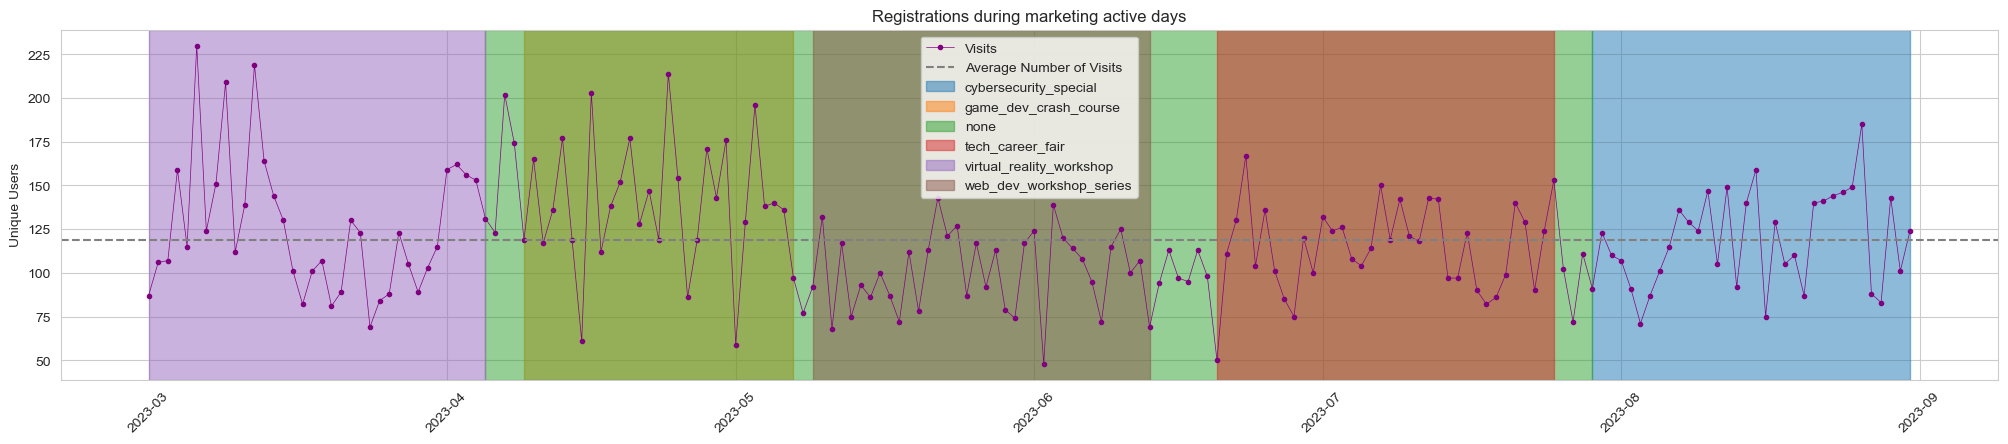

In [393]:
registrations_from_utm_campaign = ads.groupby(['date_group', 'utm_campaign']).agg({'registrations':'sum'}).reset_index()

plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
plt.title('Registrations during marketing active days')
plt.xlabel('')
plt.ylabel('Unique Users')
plt.xticks(rotation=45)
plt.plot(registrations_from_utm_campaign['date_group'], registrations_from_utm_campaign['registrations'], color = 'purple', label='Visits',
         marker='o', linewidth = 0.5, ms = 3)
plt.legend(loc='upper center')
plt.axhline(y=registrations_from_utm_campaign['registrations'].mean(), color='gray', linestyle='--', label="Average Number of Visits")
plt.legend(loc='upper center')
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), matplotlib.colors.TABLEAU_COLORS))
for _, row in ads_from_start_to_end.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.legend(loc='upper center')
plt.savefig(f'./charts/Registrations during marketing active days.png')
plt.show()

In [394]:
# df = pd.read_json('./conversion.json').head(10)
# df2 = pd.read_csv('./ads.csv').head(10)
# print(df, df2)